# Discover a newspaper collection with diachronic Ngram clouds




Ngrams are connected sequences of n items from a given text or speech sample. This means that words are not considered as individual units, but in relation to each other. For scholars in the humanities, ngrams can be helpful to get an overview of their collection or to identify discourse markers (discourse = a group of related texts belonging to a common system of formation). Ngrams can never be a research result per se - which is true for any output of NLP methods - but they can help to find important patterns in a particular collection.  

![Collection on the topic of Emigration](images/WC.PNG)

If ngrams are used to identify discourse markers, it can be useful to crate diachrinic Ngrams to explore the change of rextual patterns. This Notebook therefore shows how diachronic ngrams can be build and visualized. For cultural heritage material, visualizations should make it possible to open up and experience the collections in new ways. But they should always be linked to the original documents. 

The graphic representation and the original material cannot be perceived as two different elements, they are rather  interwoven and interact with each other. Therefore, this Notebook allows to browse the original texts within the Notebook. Thus the results of the ngram clouds can be researched in the context of the original text. 

Acknowledgments:

This work was supported by the European Union's Horizon 2020 research and innovation programme under grant 770299 (NewsEye).

## Step by step...
* [Prepare your collection](#1-bullet)
* [Install packages in command line](#2-bullet)
* [Import packages](#3-bullet)
* [Import your collection](#4-bullet)
* [Clean and tokenize the text (pre-processing)](#5-bullet)
* [Build the bigram and trigram models](#6-bullet)
* [Have a look at your collection - Create an onegram, bigram or trigram](#7-bullet)
* [Discover diachronic n-grams for specific years or time periods](#8-bullet)
* [Browse original texts](#9-bullet)


## Prepare your collection <a class="anchor" id="1-bullet"></a>

Your collection should at least contain the original text and information on the data of origin. 

## Install packages in command line <a class="anchor" id="2-bullet"></a>
 
If you need help on how to pip install, have a look at this tutorial: https://packaging.python.org/tutorials/installing-packages/

pip install gensim

pip install PyLDAvis

pip install spacy

python -m spacy download de_core_web_sm

pip install pandas

pip install regex

pip install nltk

pip install matplotlib

pip install numpy

## Import packages <a class="anchor" id="3-bullet"></a>

Before you can get started, you have to install and import some packages.

In [1]:
#languange processing imports
import gensim, spacy, logging, warnings
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
import sys
import re, numpy as np, pandas as pd
from pprint import pprint
from nltk.stem.porter import PorterStemmer
from gensim.utils import lemmatize, simple_preprocess

#For the text overview
from nltk import FreqDist

#Word Cloud and Visualization

from wordcloud import WordCloud, STOPWORDS
from sklearn.feature_extraction.text import CountVectorizer

## Import your newspaper collection <a class="anchor" id="2-bullet"></a>
And have a look at your data

In [2]:
df = pd.read_csv('y_sudtirol.csv', encoding='latin-1')

In [3]:
df.head(10)

,year,text
0,1945.0,"den. Es wird al"" unwahrscheinlich bezeichnet d..."
1,1945.0,waffnung österreichs die Brennergrenze ihre mi...
2,1945.0,Wien Samstag den 8. September 1948 kür die Rüc...
3,1945.0,beschlossen: Das Schicksal Südtirols beschäfti...
4,1945.0,Bis zum Jahre 1918 gab es in diesem Gebiete  ...
5,1945.0,tragung ausschließlich st rategische Gesichtsp...
6,1945.0,«sch anzusehenden Memoircnwerk Von Rah Stannar...
7,1945.0,"Diese fei schreibt der ""Daily T e l e g r a p ..."
8,1945.0,Wiedervereinigung mit den übrige« tirolifchest
9,1945.0,Zum Schluß komme ich au st das außenpolitische...


## Clean and tokenize the text (pre-processing) <a class="anchor" id="5-bullet"></a>

Before you can start to train the bigram and trigram models, you have to clean the text of your newspaper text blocks. The follwing functions remove punctuations, lower case the text, remove stop words and stem the text. 

#### Stop words: 
You can change the language used for the stop words. You can also add your own stop words or other words you would like to ignore. It helps to ignore your search keywords. 

In [4]:
# Functions to clean, tokenize, and stem the data
def initial_clean(text):
    text = re.sub(r'[^\w\s]','',text)
    text = text.lower() 
    text = nltk.word_tokenize(text)
    return text

stop_words = stopwords.words('german')#change the language here
# add your onw stop words
stop_words.extend(['italienisch', 'Italien', 'italienische', 'österreich', 'österreichischen', 'österreichisch','südtirolerplatz', 'südtirol', 'südtiroler', 'südtirolern', 'südtirols'])
def remove_stop_words(text):
    return [word for word in text if word not in stop_words]

stemmer = PorterStemmer()
def stem_words(text):
    try:
        text = [stemmer.stem(word) for word in text]
        text = [word for word in text if len(word) > 1] 
    except IndexError: 
        pass
    return text

def apply_all(text):
    return stem_words(remove_stop_words(initial_clean(text)))

In [5]:
df['tokenized'] = df['text'].apply(apply_all) 
print(df['tokenized'])

0       [al, unwahrscheinlich, bezeichnet, genf, ständ...
1       [waffnung, österreich, brennergrenz, militäris...
2       [wien, samstag, septemb, 1948, kür, rückkehr, ...
3       [beschlossen, schicksal, beschäftigt, neürd, w...
4       [jahr, 1918, gab, gebiet, abgesehen, gegend, e...
                              ...                        
3222    [wahlen, südfiroi, rom, dezemb, wk, ergebniss,...
3223    [rücksiediupg, südtroler, unterstützen, wien, ...
3224    [bundesministerium, inner, gebildet, aufgab, k...
3225    [politischen, wirtschaftlichen, verhältniss, w...
3226    [außenminist, graf, sforza, österreichisch, au...
Name: tokenized, Length: 3227, dtype: object


## Build the bigram and trigram models <a class="anchor" id="6-bullet"></a>
To see how often word X is followed by word Y, we build a model of the relationships between them. 

We also reduce the data to nouns, adjectives, verses and opponents. The package Spacy is used for the pos tagging. Spacy can be used in many differnt languages. To use Spazy in your preferred language, you have to install the right model. This model can be found here: https://spacy.io/usage/models. 

We lemmatize the text and remove stop words once more after lemmatization. 


In [6]:
bigram = gensim.models.Phrases(df['tokenized'], min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[df['tokenized']], threshold=100)  
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)
spacy.prefer_gpu()

def process_words(texts, stop_words=stopwords.words('german'), allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """Remove Stopwords, Form Bigrams, Trigrams and Lemmatization"""
    texts = [bigram_mod[doc] for doc in texts]
    texts = [trigram_mod[bigram_mod[doc]] for doc in texts]
    texts_out = []
    nlp = spacy.load('de_core_news_sm', disable=['parser', 'ner'])
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    # remove stopwords once more after lemmatization
    texts_out = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts_out]    
    return texts_out
    # remove stopwords once more after lemmatization


data_ready = process_words(df['tokenized'])  # processed Text Data!

## Have a look at your collection - Create an onegram, bigram or trigram <a class="anchor" id="7-bullet"></a>

Have a look at your whole collection. In the line: vectorizer = CountVectorizer(ngram_range=(3, 3)) you can change the range of the Ngram. For onegrams use (1, 1), for bigrams (2, 2) and for trigrams (3, 3).

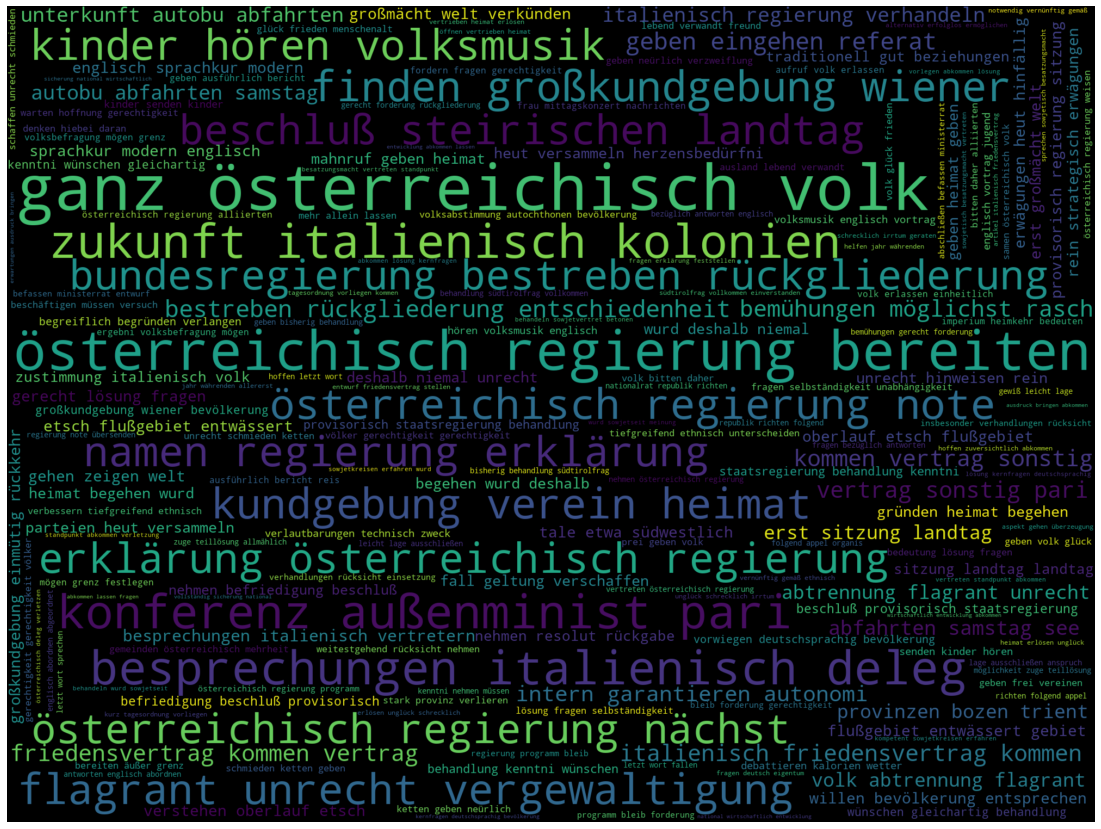

In [7]:
bigrams_list = list(nltk.bigrams(data_ready))
#print(bigrams_list)

dictionary = [' '.join([str(tup) for tup in bigrams_list])]
#print(dictionary2)

#Using count vectoriser to view the frequency of bigrams
data_ready = process_words(df['tokenized'])  # processed Text Data!
bigrams_list = list(nltk.bigrams(data_ready))
dictionary = [' '.join([str(tup) for tup in bigrams_list])]
vectorizer = CountVectorizer(ngram_range=(3, 3))
bag_of_words = vectorizer.fit_transform(dictionary)
vectorizer.vocabulary_
sum_words = bag_of_words.sum(axis=0)
words_freq = [(word, sum_words[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
words_dict = dict(words_freq)
WC_height = 1500
WC_width = 2000
WC_max_words = 200
wordCloud = WordCloud(max_words=WC_max_words, height=WC_height, width=WC_width)
wordCloud.generate_from_frequencies(words_dict)
plt.figure(figsize=(20, 15))
plt.plot
plt.imshow(wordCloud, interpolation='bilinear')
plt.axis("off")
plt.show()



## Discover diachronic n-grams for specific years or time periods <a class="anchor" id="8-bullet"></a>

Here you can create diachronic Ngram clouds for specific years or time frames. 

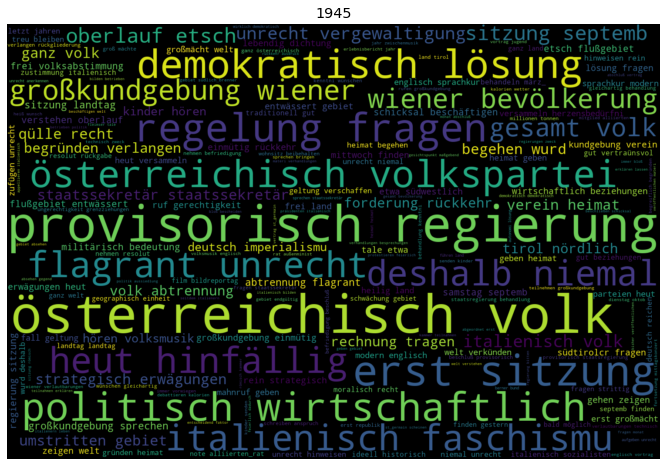

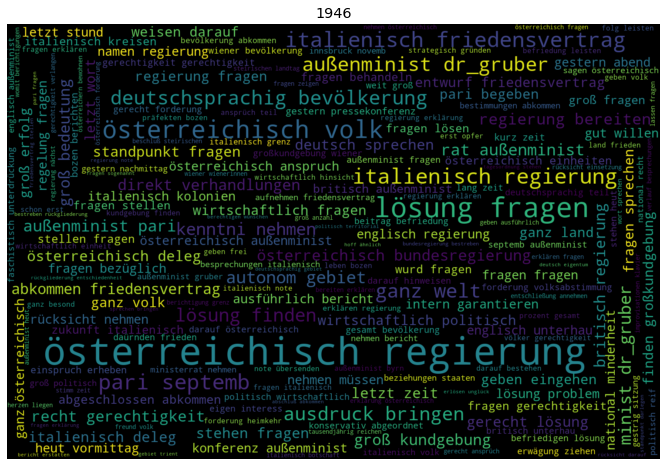

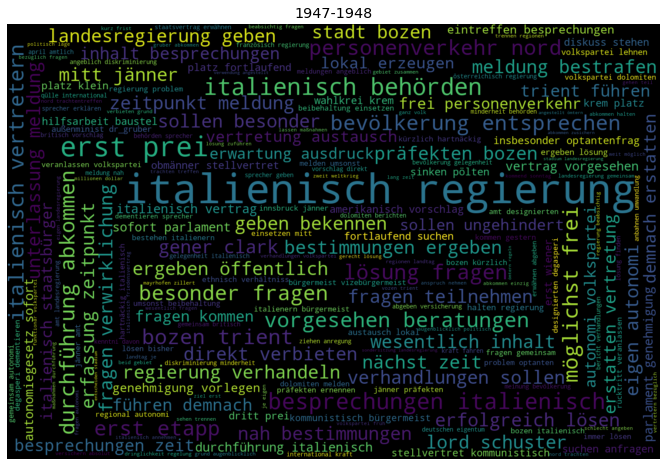

In [8]:
#Choose specific years or time frames you want to use for the NGram clouds
_1945 = (df['year'] > int('1944')) & (df['year'] <= int('1945'))
_1946 = (df['year'] > int('1945')) & (df['year'] <= int('1946'))
_1947_48 = (df['year'] > int('1946')) & (df['year'] <= int('1947'))

#This will be used for the title of the clouds
time_frame = ['1945', '1946', '1947-1948']

#Here you create a list containing the information on your selected time-frames
selection = []
selection.append(_1945)
selection.append(_1946)
selection.append(_1947_48)

#Get your bigrams for every selected time frame
selection[0] = df.loc[_1945]['tokenized']
selection[1] = df.loc[_1946]['tokenized']
selection[2] = df.loc[_1947_48]['tokenized']

#Create the diachronic Ngram clouds
i = -1
while i < len(selection) -1:
    i = i +1 
    data_ready2 = process_words(selection[i])  # processed Text Data!
    bigrams_list = list(nltk.bigrams(data_ready2))
    dictionary = [' '.join([str(tup) for tup in bigrams_list])]
    vectorizer = CountVectorizer(ngram_range=(2, 2))
    bag_of_words = vectorizer.fit_transform(dictionary)
    vectorizer.vocabulary_
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    words_dict = dict(words_freq)
    WC_height = 1000
    WC_width = 1500
    WC_max_words = 200
    wordCloud = WordCloud(max_words=WC_max_words, height=WC_height, width=WC_width)
    wordCloud.generate_from_frequencies(words_dict)
    plt.figure(figsize=(15, 8))
    plt.plot
    plt.imshow(wordCloud, interpolation='bilinear')
    plt.title(time_frame[i], size= 'x-large')
    plt.axis("off")
    plt.show()

## Browse original texts <a class="anchor" id="9-bullet"></a>

Here you can browse through the original text. To refine the search, you can reduce the search to those texts that contain a specific word. In this example all texts were searched containg the word "amerika*". 

In [9]:
pd.set_option('display.max_colwidth', -1)

lines_ = []
for line in df['text']:
    if 'amerika' in line:
        lines_.append(line)
    
lines_ = pd.DataFrame(lines_, columns =['Amerika'])
df_select = pd.DataFrame(lines_['Amerika'])
df_select    


,Amerika
0,"Das Kleine Volksblatt Donnerstag 4. Oktober 1945 Nr. 51 Südtirol Ein amerikanischer Journalist hat vor Jahre über die österreicher folgendes geschrieben. ""Sie neigen gerne zu Parteibildungen und be kämpfen sich dann gegenseitig mit ziemlicher Hef-"
1,M^er anderem-auch die wie das amerikanische Durch ferne eigenartige geschichtliche Entwicklung war Volk über österreichs Mitschuld am Tirol zu einer festgefügten historischen und Wirtschaft.
2,"der Strasse ein grosser Unterschied besteht. Die der eingeengt zwischen dem Deutschen Reich und Italien amerikanischen Soldaten seien der Ansicht wer im wesevtlicheu nur aus d«m Jnuial und Hessen Seiten- «unr Wmf- talern besteht. Das Land Tirol verlor durch die ""nnatür. deutsch rrd.et. se.i eben DtzuLscher mnd damit schul- Grenzziehung am Brenner nicht nur Südtirol. ' . . WWW WY. . ... . . _es dig. Der amerskayisrhe Bürger hingegen sehe in wurde auch von Otzti.ro l g-e trennt da die"
3,Besetzung und Erziehung Japans behandelt. Dieser Plan sieht hauptsächlich eine amerikanische Kontrolle mit Hilfe von Vertretern der vier Alliierten vor. Frankreich und die Südtiroler Frage Paris 8. September In politischen Kreisen verlautet Frankreich
4,der amerikanischen Armee in österreich
5,lienische Ministerpräsident Bonomi erklärte daß Italien dem angto-amerikanischen Sinn sür Gerechtigkeit und Billigkeit vertraün dürfe und keine harten Fricdcnsbedingungen zu befürchten habe. Bonomi drückte den Wunsch Italiens aus seine Vorkriegsgrcnzen im Norden beizubehalten. Italien halte auch an dem Brennerpaß und an der Südtiroler Alpen- grenze fest.
6,I n n s b r n i» 1. Juni (AND). Prof. Dr. R e « «-N ie» l u I! i Hai an Präsident Truman solgendes Telegram gerichtet: Namens des Volkes Südtirols einschliri! lich 3Ü.UUV durch Hitler und Muffolini vertrielicM Landsleute richte ich an das Volk der USA die Dci6i' Bitte die Sache der F r e i h e i 1 « n d © r r e ch tigkcit in der Tiroler Frage zu »nie! stützen. Unser gesamtes Voll beschwört die groß amerikanische Nation die Heimkehr Südtirols iij
7,Prinzipien zum Durchbruch verhelfe». Im Jahre 1916 wurde aber der Anspruch O e st e r- reichs durchkreuzt offenbar um T r i e st den Italienern zu erhalten wie es 1919 geschah um Fiume den Italienern vorzünthalten. Es erfüllt das österreichische Bolk mit Schmerz dah diese große und mächtige Nation ihren Einfluß nicht auch zum Schutze der Südtiroler geltend machen kann die dessen am meisten bedürfen. Die stets hilfsbereite Tatkraft amerikanischer Offiziere und Soldaten in Österreich lieh uns erwarten dah wir auch in dieser Frage auf Unterstützung hoffen dürfen. Unsere Lage 14 Monate nach der Befreiung
8,Italien beharrt auf seinem ablehnenden Standpunkt Rom 5. Februar (ACA) Nachdem gestern Ministerpräsident de Gasperi dem amerikanischen britischen französischen und russischen Botschafter ein italienisches Memorandum über den Südtiroler Grenzstreit mit Österreich überreicht hat in dem die italienischen Gründe für die Zurückbehaltung des Alpengebietes einschließlich des strategisch wichtigen Brennerpasses angeführt werden wird jetzt eine Rede des stellvertretenden Ministerpräsidenten N e n n i bekannt in der dieser die österreichischen Ansprüche auf Südtirol als nicht berechtigt erklärt. Territoriale Ansprüche und alle Grenzfragen sind im Interesse ganz Europas zu lösen.
9,Im Zusammenhang mit der vom Hauptquartier der amerikanischen Armee veröffentlichten Mitteilung über die letzte Sitzung des Alliierten Rates wandte sich ein TASS-Korrespon- dent an die Vertreter des Sowjetjsommandos Wien-Simmering Geiselbergstraße zum Arzt gegangen und nicht mehr zur'ückgekommen. Sie ist bis heute abgängig. Mitteilungen an ihren Vater Raföl Wagner Amstetten bei Firma Julius Berger Lagerplatz _ Hilfe für Südtirol Tausende und aber Tausende von österreichischen Familien haben Verwandte und Bekannte im Ausland. Helfen Sie uns bei unserem Bemühen Südtirol zurückzugewinnen und senden Sie dem Verband der Südtiroler Innsbruck. Maria-T